En este notebook armo el stitcher version full.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from imagen import Imagen

plt.rcParams['figure.figsize'] = [20, 10] #modificar si queremos mayor tamano de las figuras

In [ ]:
# fittea solo traslacion!!! despues hago una con escalado tambien a ver que ondis
def fittear( ptData, ptTrain ):
    return np.float32( [
        [1, 0, ptTrain[0] - ptData[0]],
        [0, 1, ptTrain[1] - ptData[1]],
        [0, 0, 1]
    ] )

def calcularInliers( ptsData, ptsTrain, H, tolerancia):
    ptsData = np.block([ ptsData, np.ones( ( ptsData.shape[0], 1 )) ])
    ptsTrain = np.block([ ptsTrain, np.ones( ( ptsTrain.shape[0], 1 )) ])
    E = H@ptsData.T - ptsTrain.T

    return np.sum( [ np.dot( e,e ) < np.power(tolerancia, 2) for e in E.T  ] )

In [ ]:
# computa matriz homografica H tal que H D_i = T_i
def matrizHomografica( ptsData, ptsTrain, tolerancia, maxIteraciones ):
    mejorFitteo = (np.eye(3), -np.inf) # matriz asociada y inliners
    for i in range(maxIteraciones):
        indiceInicial = np.random.randint(0, len(ptsData))
        H = fittear(ptsData[indiceInicial], ptsTrain[indiceInicial])
        cantInliers = calcularInliers(ptsData, ptsTrain, H, tolerancia)

        mejorFitteo = (H, cantInliers) if cantInliers > mejorFitteo[1] else mejorFitteo

    return mejorFitteo


In [ ]:
def matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras=None):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    print("        comenzando matcheo")
    if mascaras is None:
        rawMatches = matcher.knnMatch(imagenB.features, imagenA.features, 2)
    else:
        rawMatches = matcher.knnMatch(imagenB.getFeatures(mascaras[1]), imagenA.getFeatures(mascaras[0]), 2)
    matches = []
    
    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    print("            hubo ", len(matches), " matcheos")
    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = matrizHomografica( ptsB, ptsA, tolerancia, len(ptsB))

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        
def stitchPar(imagenA, imagenB, ratio, tolerancia, mascaras=None, limite=None):
    (matches, H, inliners) = matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras)
    
    imagenB.transformar(H, limite)
    imagenA.mover(int(np.abs(np.clip(np.min([esquina[0] for esquina in imagenB.esquinas]), None, 0))),
                  int(np.abs(np.clip(np.min([esquina[1] for esquina in imagenB.esquinas]), None, 0))))
    
    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        3
    )
    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor, np.zeros(resultShape[0:2], np.uint8) )

    result.pegar(imagenA)
    result.pegar(imagenB)

    return result

def stitch( imagenes, grilla , orden, ratioMascaraW=0.3, ratioMascaraH=0.5 ):
    indice = 0
    panorama = None
    print("comenzando pegando...")
    for fila in range(grilla[0]):
        imagenFila = imagenes[orden[indice] - 1]
        anchoUltimaPegada = imagenFila.shape[1]
        for col in range(grilla[1] - 1):
            print("    ->par ", indice + 1)
            imagenAPegar = imagenes[orden[indice + 1] - 1]
            mascaras = [ 
                Imagen.crearMascara(imagenFila.shape, (anchoUltimaPegada * ratioMascaraW) / imagenFila.shape[1] if col != 0 else ratioMascaraW),
                Imagen.crearMascara(imagenAPegar.shape, ratioMascaraW, orden=1)
            ]
            anchoUltimaPegada = imagenAPegar.shape[1]
            imagenFila = stitchPar( imagenFila, imagenAPegar, ratio, tolerancia, mascaras=mascaras )
            indice += 1
        indice += 1

        if panorama is None:
            panorama = imagenFila
        else:
            mascaras = [ 
                Imagen.crearMascara(panorama.shape, (altoUltimaFilaPegada * ratioMascaraH) / panorama.shape[0] if fila != 0 else ratioMascaraH, eje=1),
                Imagen.crearMascara(imagenFila.shape, ratioMascaraH, eje=1, orden=1)
            ]
            panorama = stitchPar( panorama, imagenFila, ratio, tolerancia, mascaras=mascaras)

        altoUltimaFilaPegada = imagenFila.shape[0]

    return panorama.imagen

In [ ]:
descriptor = cv2.xfeatures2d.SURF_create()
grilla = (3,4)
orden = [ i if int((i-1)/4) % 2 == 0 else 4*(int((i-1)/4)+1) - (i-1)%4 for i in range(1, grilla[0] * grilla[1] + 1)]

In [ ]:
ratio = 0.75
tolerancia = 4

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/' + f"{i:02d}" + '.tif'), descriptor ) for i in range(1,41)]

res = stitch(imagenes, grilla, orden)

In [ ]:
plt.imshow(res[...,::-1])

# Todo bien... pero es lento lento

In [ ]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from imagen import Imagen

plt.rcParams['figure.figsize'] = [20, 10] #modificar si queremos mayor tamano de las figuras

In [ ]:
time_matchear = []
time_transformacion = []
time_pegar = []
time_mascaras = []

In [ ]:
def medir( f, out ):
    start = time.perf_counter()
    res = f()
    end = time.perf_counter()

    out.append(end - start)

    return res

In [ ]:
# fittea solo traslacion!!! despues hago una con escalado tambien a ver que ondis
def fittear( ptData, ptTrain ):
    return np.float32( [
        [1, 0, ptTrain[0] - ptData[0]],
        [0, 1, ptTrain[1] - ptData[1]],
        [0, 0, 1]
    ] )

def calcularInliers( ptsData, ptsTrain, H, tolerancia):
    ptsData = np.block([ ptsData, np.ones( ( ptsData.shape[0], 1 )) ])
    ptsTrain = np.block([ ptsTrain, np.ones( ( ptsTrain.shape[0], 1 )) ])
    E = H@ptsData.T - ptsTrain.T

    return np.sum( [ np.dot( e,e ) < np.power(tolerancia, 2) for e in E.T  ] )

In [ ]:
# computa matriz homografica H tal que H D_i = T_i
def matrizHomografica( ptsData, ptsTrain, tolerancia, maxIteraciones ):
    mejorFitteo = (np.eye(3), -np.inf) # matriz asociada y inliners
    for i in range(maxIteraciones):
        indiceInicial = np.random.randint(0, len(ptsData))
        H = fittear(ptsData[indiceInicial], ptsTrain[indiceInicial])
        cantInliers = calcularInliers(ptsData, ptsTrain, H, tolerancia)

        mejorFitteo = (H, cantInliers) if cantInliers > mejorFitteo[1] else mejorFitteo

    return mejorFitteo


In [ ]:
def matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras=None):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    print("        comenzando matcheo")
    if mascaras is None:
        rawMatches = medir( lambda: matcher.knnMatch(imagenB.features, imagenA.features, 2), time_matchear)
    else:
        rawMatches = medir( lambda: matcher.knnMatch(imagenB.getFeatures(mascaras[1]), imagenA.getFeatures(mascaras[0]), 2), time_matchear)
    matches = []
    
    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    print("            hubo ", len(matches), " matcheos")
    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = medir( lambda: matrizHomografica( ptsB, ptsA, tolerancia, len(ptsB)), time_transformacion)

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        
def stitchPar(imagenA, imagenB, ratio, tolerancia, mascaras=None, limite=None):
    (matches, H, inliners) = matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras)
    
    imagenB.transformar(H, limite)
    imagenA.mover(int(np.abs(np.clip(np.min([esquina[0] for esquina in imagenB.esquinas]), None, 0))),
                  int(np.abs(np.clip(np.min([esquina[1] for esquina in imagenB.esquinas]), None, 0))))
    
    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        3
    )

    start = time.perf_counter()
    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor, np.zeros(resultShape[0:2], np.uint8) )

    result.pegar(imagenA)
    result.pegar(imagenB)
    end = time.perf_counter()
    time_pegar.append(end - start)

    return result

def stitch( imagenes, grilla , orden, ratioMascaraW=0.3, ratioMascaraH=0.5 ):
    indice = 0
    panorama = None
    print("comenzando pegando...")
    for fila in range(grilla[0]):
        imagenFila = imagenes[orden[indice] - 1]
        anchoUltimaPegada = imagenFila.shape[1]
        for col in range(grilla[1] - 1):
            #print("    ->par ", indice + 1)
            imagenAPegar = imagenes[orden[indice + 1] - 1]
            mascaras = medir( lambda: [ 
                Imagen.crearMascara(imagenFila.shape, (anchoUltimaPegada * ratioMascaraW) / imagenFila.shape[1] if col != 0 else ratioMascaraW),
                Imagen.crearMascara(imagenAPegar.shape, ratioMascaraW, orden=1)
            ], time_mascaras)
            anchoUltimaPegada = imagenAPegar.shape[1]
            imagenFila = stitchPar( imagenFila, imagenAPegar, ratio, tolerancia, mascaras=mascaras )
            indice += 1
        indice += 1

        if panorama is None:
            panorama = imagenFila
        else:
            mascaras = medir( lambda: [ 
                Imagen.crearMascara(panorama.shape, (altoUltimaFilaPegada * ratioMascaraH) / panorama.shape[0] if fila != 0 else ratioMascaraH, eje=1),
                Imagen.crearMascara(imagenFila.shape, ratioMascaraH, eje=1, orden=1)
            ], time_mascaras)
            panorama = stitchPar( panorama, imagenFila, ratio, tolerancia, mascaras=mascaras)

        altoUltimaFilaPegada = imagenFila.shape[0]

    return panorama.imagen

In [ ]:
descriptor = cv2.xfeatures2d.SURF_create()
grilla = (5,4)
orden = [ i if int((i-1)/4) % 2 == 0 else 4*(int((i-1)/4)+1) - (i-1)%4 for i in range(1, grilla[0] * grilla[1] + 1)]

In [ ]:
ratio = 0.75
tolerancia = 4

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/' + f"{i:02d}" + '.tif'), descriptor ) for i in range(1,41)]

res = stitch(imagenes, grilla, orden)

In [ ]:
iteraciones = len(time_mascaras)
plt.figure(0)
plt.plot( range(1, iteraciones + 1), time_mascaras, marker='.', label='tiempo mascaras' )
plt.plot( range(1, iteraciones + 1), time_matchear, marker='.', label='tiempo describir-matchear' )
plt.plot( range(1, iteraciones + 1), time_transformacion, marker='.', label='tiempo hayar transfo' )
plt.plot( range(1, iteraciones + 1), time_pegar, marker='.', label='tiempo pegado' )
plt.legend()
plt.show()

Okey... hayar la transformacion es caro, pero esto se soluciona muy facil. estoy ejecutando ransac sin limite de iteraciones, entonces prueba con todos los features. Hay que poner una cota descente y listo.

Lo otro que cuesta es describir y matchear. Esto tal vez lo podemos arreglar cambiando el método de matcheo (no usar knn con brute force).

Como eligo cota descente para el ransac?

supongamos que la proba de que un feature sea un outlier es 0.15, entonces la proba de que en K iteraciones no haya agarrado un inlier es

$$ (0.15)^{K} $$

Entonces si quiero el menor K tal que la probabilidad de que haya sampleado al menos 1 inlier sea mayor a 0.95 tengo que

$$ 1 - (0.15)^{K} > 0.95 $$

In [ ]:
plt.figure(1)
plt.plot( np.arange(1, 11), [1 - np.power(0.15, K) for K in np.arange(1, 11)], label="p = 0.15")
plt.plot( np.arange(1, 11), [1 - np.power(0.2, K) for K in np.arange(1, 11)], label="p = 0.2")
plt.plot( np.arange(1, 11), [1 - np.power(0.3, K) for K in np.arange(1, 11)], label="p = 0.3")
plt.plot( np.arange(1, 11), [1 - np.power(0.5, K) for K in np.arange(1, 11)], label="p = 0.5")
plt.plot( np.arange(1, 11), [1 - np.power(0.75, K) for K in np.arange(1, 11)], label="p = 0.75")
plt.grid(True)
plt.legend()
plt.show()

podemos ver que incluso cuando tenemos 50% de outliers (que es un caso raro) alcanza con 4 iteraciones para tener una confianza mayor al 90%.
Con 75% de outliers necesitariamos 8 iteraciones, que no deberia ser mucho mas costoso. Asi que parece un buen numero para empezar a experimentar.

Si quisieramos ser muy cuidadosos podriamos incluso ir hasta 20-30 y deberiamos tener excelentes resultados a un costo muchisimo menor. Estabamos teniendo hasta 1600 matcheos en las imagenes ejemplo de recien.

# Parametro ransac

In [51]:
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from imagen import Imagen

plt.rcParams['figure.figsize'] = [20, 10] #modificar si queremos mayor tamano de las figuras

In [52]:
time_matchear = []
time_transformacion = []
time_pegar = []
time_mascaras = []

In [53]:
def medir( f, out ):
    start = time.perf_counter()
    res = f()
    end = time.perf_counter()

    out.append(end - start)

    return res

In [54]:
# fittea solo traslacion!!! despues hago una con escalado tambien a ver que ondis
def fittear( ptData, ptTrain ):
    return np.float32( [
        [1, 0, ptTrain[0] - ptData[0]],
        [0, 1, ptTrain[1] - ptData[1]],
        [0, 0, 1]
    ] )

def calcularInliers( ptsData, ptsTrain, H, tolerancia):
    ptsData = np.block([ ptsData, np.ones( ( ptsData.shape[0], 1 )) ])
    ptsTrain = np.block([ ptsTrain, np.ones( ( ptsTrain.shape[0], 1 )) ])
    E = H@ptsData.T - ptsTrain.T

    return np.sum( [ np.dot( e,e ) < np.power(tolerancia, 2) for e in E.T  ] )

In [55]:
# computa matriz homografica H tal que H D_i = T_i
def matrizHomografica( ptsData, ptsTrain, tolerancia, maxIteraciones ):
    mejorFitteo = (np.eye(3), -np.inf) # matriz asociada y inliners
    for i in range(maxIteraciones):
        indiceInicial = np.random.randint(0, len(ptsData))
        H = fittear(ptsData[indiceInicial], ptsTrain[indiceInicial])
        cantInliers = calcularInliers(ptsData, ptsTrain, H, tolerancia)

        mejorFitteo = (H, cantInliers) if cantInliers > mejorFitteo[1] else mejorFitteo

    return mejorFitteo


In [56]:
def matchearImagenes(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras=None):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    if mascaras is None:
        rawMatches = medir( lambda: matcher.knnMatch(imagenB.features, imagenA.features, 2), time_matchear)
    else:
        rawMatches = medir( lambda: matcher.knnMatch(imagenB.getFeatures(mascaras[1]), imagenA.getFeatures(mascaras[0]), 2), time_matchear)
    matches = []
    
    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    
    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = medir( lambda: matrizHomografica( ptsB, ptsA, tolerancia, maxIteracionesRansac), time_transformacion)

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        
def stitchPar(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras=None, limite=None):
    (matches, H, inliners) = matchearImagenes(imagenA, imagenB, ratio, tolerancia, maxIteracionesRansac, mascaras)
    
    imagenB.transformar(H, limite)
    imagenA.mover(int(np.abs(np.clip(np.min([esquina[0] for esquina in imagenB.esquinas]), None, 0))),
                  int(np.abs(np.clip(np.min([esquina[1] for esquina in imagenB.esquinas]), None, 0))))
    
    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        3
    )

    start = time.perf_counter()
    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor, np.zeros(resultShape[0:2], np.uint8) )

    result.pegar(imagenA)
    result.pegar(imagenB)
    end = time.perf_counter()
    time_pegar.append(end - start)

    return result

def stitch( imagenes, grilla , orden, maxIteracionesRansac, ratioMascaraW=0.3, ratioMascaraH=0.5 ):
    indice = 0
    panorama = None
    print("comenzando pegando...")
    for fila in range(grilla[0]):
        imagenFila = imagenes[orden[indice] - 1]
        anchoUltimaPegada = imagenFila.shape[1]
        for col in range(grilla[1] - 1):
            #print("    ->par ", indice + 1)
            imagenAPegar = imagenes[orden[indice + 1] - 1]
            mascaras = medir( lambda: [ 
                Imagen.crearMascara(imagenFila.shape, (anchoUltimaPegada * ratioMascaraW) / imagenFila.shape[1] if col != 0 else ratioMascaraW),
                Imagen.crearMascara(imagenAPegar.shape, ratioMascaraW, orden=1)
            ], time_mascaras)
            anchoUltimaPegada = imagenAPegar.shape[1]
            imagenFila = stitchPar( imagenFila, imagenAPegar, ratio, tolerancia, maxIteracionesRansac, mascaras=mascaras )
            indice += 1
        indice += 1

        if panorama is None:
            panorama = imagenFila
        else:
            mascaras = medir( lambda: [ 
                Imagen.crearMascara(panorama.shape, (altoUltimaFilaPegada * ratioMascaraH) / panorama.shape[0] if fila != 0 else ratioMascaraH, eje=1),
                Imagen.crearMascara(imagenFila.shape, ratioMascaraH, eje=1, orden=1)
            ], time_mascaras)
            panorama = stitchPar( panorama, imagenFila, ratio, tolerancia, maxIteracionesRansac, mascaras=mascaras)

        altoUltimaFilaPegada = imagenFila.shape[0]

    return panorama.imagen

In [57]:
descriptor = cv2.xfeatures2d.SURF_create()
grilla = (5,4)
orden = [ i if int((i-1)/4) % 2 == 0 else 4*(int((i-1)/4)+1) - (i-1)%4 for i in range(1, grilla[0] * grilla[1] + 1)]

In [58]:
ratio = 0.75
tolerancia = 4

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/' + f"{i:02d}" + '.tif'), descriptor ) for i in range(1,41)]

res = stitch(imagenes, grilla, orden, maxIteracionesRansac=8)

comenzando pegando...


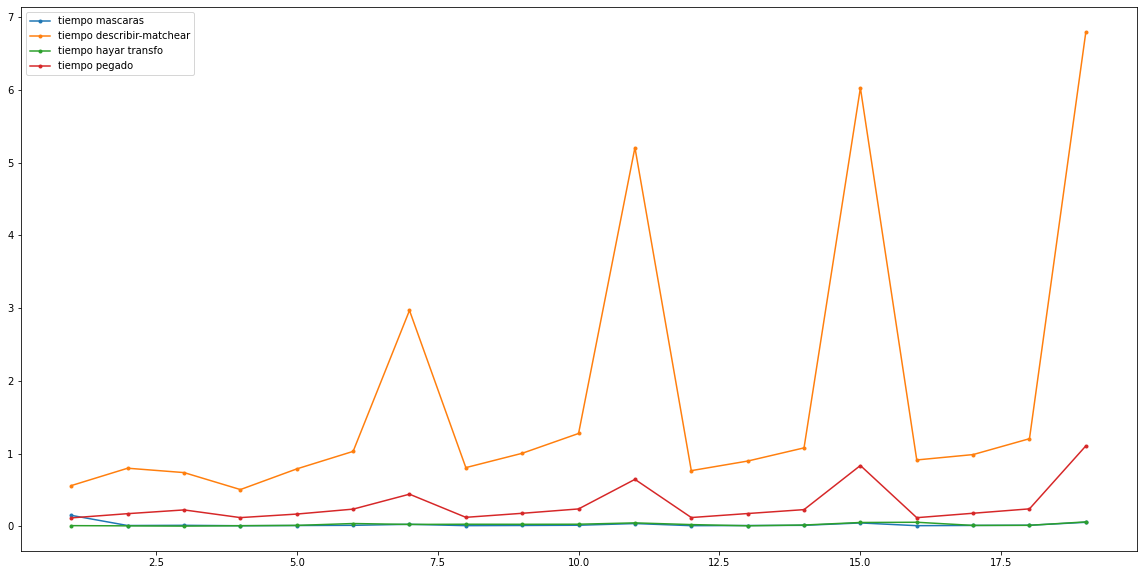

In [59]:
iteraciones = len(time_mascaras)
plt.figure(0)
plt.plot( range(1, iteraciones + 1), time_mascaras, marker='.', label='tiempo mascaras' )
plt.plot( range(1, iteraciones + 1), time_matchear, marker='.', label='tiempo describir-matchear' )
plt.plot( range(1, iteraciones + 1), time_transformacion, marker='.', label='tiempo hayar transfo' )
plt.plot( range(1, iteraciones + 1), time_pegar, marker='.', label='tiempo pegado' )
plt.legend()
plt.show()

se re planchó el costo de hayar la transformacion... como es el resultado

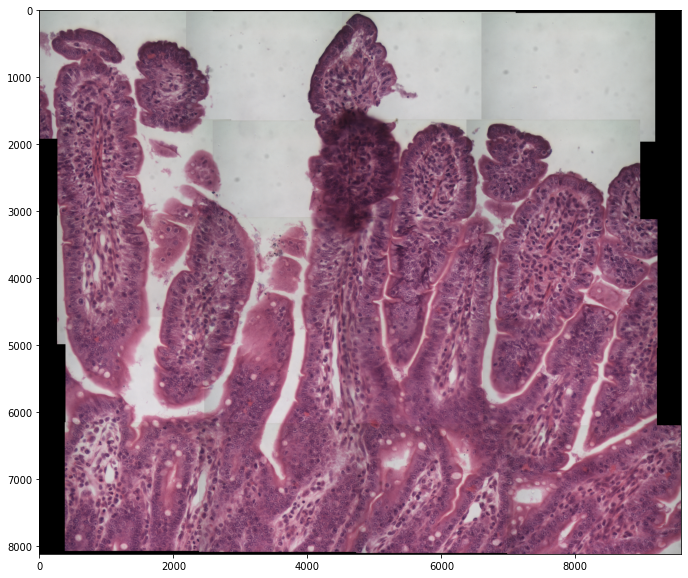

In [60]:
plt.imshow(res[...,::-1])

igual de bueno que cuando lo haciamos para todos los features!!